In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import requests
from xml.etree import ElementTree as ET
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [316]:
## CNH 데이터 입력
CNH_df = pd.read_csv('C:/Muzin/Fixers_C/USD_CNH 과거 데이터.csv')

# CNH 시간, 종가, 시가, 고가, 저가 분리
CNH_df_Time = CNH_df.iloc[:, 0]
CNH_df_Ed = CNH_df.iloc[:, 1]
CNH_df_St = CNH_df.iloc[:, 2]
CNH_df_Hi = CNH_df.iloc[:, 3]
CNH_df_Lw = CNH_df.iloc[:, 4]
CNH_data=[CNH_df_Ed, CNH_df_St, CNH_df_Hi, CNH_df_Lw]

## DTW 분석 데이터 입력
# CNH_고가
DTW_df_Hi = pd.read_csv('C:/Muzin/Fixers_C/DTW_data/CNH_Hi.csv')
DTW_df_Hi_Time = DTW_df_Hi.iloc[:,0]
DTW_df_Hi.drop(DTW_df_Hi.columns[0], axis=1, inplace = True)

# CNH_저가
DTW_df_Lw = pd.read_csv('C:/Muzin/Fixers_C/DTW_data/CNH_Lw.csv')
DTW_df_Lw_Time = DTW_df_Lw.iloc[:,0]
DTW_df_Lw.drop(DTW_df_Lw.columns[0], axis=1, inplace = True)

# CNH_시가
DTW_df_St = pd.read_csv('C:/Muzin/Fixers_C/DTW_data/CNH_St.csv')
DTW_df_St_Time = DTW_df_St.iloc[:,0]
DTW_df_St.drop(DTW_df_St.columns[0], axis=1, inplace = True)

# CNH_종가
DTW_df_Ed = pd.read_csv('C:/Muzin/Fixers_C/DTW_data/CNH_Ed.csv')
DTW_df_Ed_Time = DTW_df_Ed.iloc[:,0]
DTW_df_Ed.drop(DTW_df_Ed.columns[0], axis=1, inplace = True)

In [317]:
# 데이터 점검용 콘솔
print(DTW_df_Hi)
print(CNH_df_Hi)

         15       16     18    19
0   7.42250  7.28500  6.822  7.08
1   7.34000  7.03750  6.712  7.21
2   7.32000  7.17000  6.725  7.30
3   7.18250  7.01000  6.564  7.17
4   7.12028  6.78500  6.416  7.35
5   6.77000  6.66250  6.270  7.33
6   6.78000  6.77000  6.282  7.68
7   6.92250  6.73000  6.460  7.34
8   6.80188  6.71000  6.377  7.44
9   6.65750  6.65750  6.350  7.07
10  6.64500  6.64500  6.080  6.91
11  6.41750  6.28000  6.130  7.30
12  6.65000  6.61250  5.961  7.18
13  6.75750  6.54000  6.172  7.58
14  6.82500  6.68000  6.240  7.60
15  6.94250  6.90000  6.354  7.60
16  7.23250  7.13000  6.604  7.30
17  7.01750  6.86000  6.765  7.18
18  6.99699  6.78750  6.418  7.19
19  6.83250  6.64000  6.324  7.36
20  6.76000  6.55250  6.319  6.65
21  6.74500  6.57000  6.350  6.92
22  6.86250  6.68500  6.348  6.75
23  7.12000  6.82772  6.467  6.92
24  6.90000  6.82000  6.658  6.80
25  7.50000  7.07250  6.432  7.25
26  7.23750  7.16750  7.160  6.81
27  7.45000  7.45000  6.789  7.08
28  7.58250  7

In [341]:
## 목표 데이터(CNH)와 DTW 데이터 결합
# 고가 인덱싱
CNH_df_Hi.index = pd.to_datetime(CNH_df_Time)
DTW_df_Hi.index = pd.to_datetime(DTW_df_Hi_Time)
CNH_df_Hi_com = pd.merge(CNH_df_Hi, DTW_df_Hi, left_index=True, right_index=True)
CNH_df_Hi_Time = pd.merge(CNH_df_Time, DTW_df_Hi_Time, left_index=True, right_index=True)
CNH_df_Hi_Time.drop(CNH_df_Hi_Time.columns[0], axis=1, inplace = True)

# 저가 인덱싱
CNH_df_Lw.index = pd.to_datetime(CNH_df_Time)
DTW_df_Lw.index = pd.to_datetime(DTW_df_Lw_Time)
CNH_df_Lw_com = pd.merge(CNH_df_Lw, DTW_df_Lw, left_index=True, right_index=True)
CNH_df_Lw_Time = pd.merge(CNH_df_Time, DTW_df_Lw_Time, left_index=True, right_index=True)
CNH_df_Lw_Time.drop(CNH_df_Lw_Time.columns[0], axis=1, inplace = True)

# 시가 인덱싱
CNH_df_St.index = pd.to_datetime(CNH_df_Time)
DTW_df_St.index = pd.to_datetime(DTW_df_St_Time)
CNH_df_St_com = pd.merge(CNH_df_St, DTW_df_St, left_index=True, right_index=True)
CNH_df_St_Time = pd.merge(CNH_df_Time, DTW_df_St_Time, left_index=True, right_index=True)
CNH_df_St_Time.drop(CNH_df_St_Time.columns[0], axis=1, inplace = True)

# 고가 인덱싱
CNH_df_Ed.index = pd.to_datetime(CNH_df_Time)
DTW_df_Ed.index = pd.to_datetime(DTW_df_Ed_Time)
CNH_df_Ed_com = pd.merge(CNH_df_Ed, DTW_df_Ed, left_index=True, right_index=True)
CNH_df_Ed_Time = pd.merge(CNH_df_Time, DTW_df_Ed_Time, left_index=True, right_index=True)
CNH_df_Ed_Time.drop(CNH_df_Ed_Time.columns[0], axis=1, inplace = True)

In [343]:
### 이하 자료는 CNH_df_Hi_com에 대한 분석치
## 데이터프레임 점검
print(CNH_df_Hi_Time)
print(CNH_df_Lw_Time)
print(CNH_df_St_Time)
print(CNH_df_Ed_Time)
print(CNH_df_Hi_com)
print(CNH_df_Lw_com)
print(CNH_df_St_com)
print(CNH_df_Ed_com)

          Date
0   2023-08-16
1   2023-08-17
2   2023-08-18
3   2023-08-21
4   2023-08-22
5   2023-08-23
6   2023-08-24
7   2023-08-25
8   2023-08-29
9   2023-08-30
10  2023-08-31
11  2023-09-01
12  2023-09-04
13  2023-09-05
14  2023-09-06
15  2023-09-07
16  2023-09-08
17  2023-09-11
18  2023-09-12
19  2023-09-13
20  2023-09-14
21  2023-09-15
22  2023-09-18
23  2023-09-19
24  2023-09-20
25  2023-09-21
26  2023-09-22
27  2023-09-25
28  2023-09-26
29  2023-09-27
30  2023-09-28
31  2023-09-29
32  2023-10-02
33  2023-10-03
34  2023-10-04
35  2023-10-05
36  2023-10-06
37  2023-10-09
38  2023-10-10
39  2023-10-11
40  2023-10-12
41  2023-10-13
42  2023-10-16
43  2023-10-17
44  2023-10-18
45  2023-10-19
46  2023-10-20
47  2023-10-23
48  2023-10-24
49  2023-10-25
50  2023-10-26
51  2023-10-27
52  2023-10-30
53  2023-10-31
54  2023-11-01
55  2023-11-02
          Date
0   2023-08-16
1   2023-08-17
2   2023-08-18
3   2023-08-21
4   2023-08-22
5   2023-08-23
6   2023-08-24
7   2023-08-25
8   2023-0

In [344]:
## 다중공선성 확인 및 데이터 점검
#고가 기준 테스트
X = CNH_df_Hi_com.iloc[:,1:]
y = CNH_df_Hi_com.iloc[:,0]

vif = [variance_inflation_factor(X.values, i)for i in range(X.shape[1])]

result = sm.OLS(y,X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                     고가   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              6067.
Date:                Mon, 06 Nov 2023   Prob (F-statistic):                    1.03e-68
Time:                        14:39:54   Log-Likelihood:                         -18.811
No. Observations:                  56   AIC:                                      45.62
Df Residuals:                      52   BIC:                                      53.72
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [345]:
## n_components = 2 에서의 PCA 수행
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['p1','p2'])

# 자료형 확인
principalDf.head()

,p1,p2
0,0.076188,0.280231
1,0.283515,0.098536
2,0.194337,0.025555
3,0.483345,0.083254
4,0.677676,-0.152361


In [346]:
# 설명력 확인
pca.explained_variance_ratio_

array([0.85874785, 0.09553407])

In [347]:
# 설명력 총계 확인
sum(pca.explained_variance_ratio_)

0.9542819222420609

In [348]:
# 데이터 전체 확인
principalDf.index = CNH_df_Hi_Time
principalDf

,p1,p2
"(2023-08-16,)",0.076188,0.280231
"(2023-08-17,)",0.283515,0.098536
"(2023-08-18,)",0.194337,0.025555
"(2023-08-21,)",0.483345,0.083254
"(2023-08-22,)",0.677676,-0.152361
"(2023-08-23,)",1.026860,-0.211201
"(2023-08-24,)",0.868182,-0.533442
"(2023-08-25,)",0.791408,-0.153322
"(2023-08-29,)",0.892223,-0.282478
"(2023-08-30,)",1.110121,0.048501


In [349]:
## 데이터 정리
# 주성분 분리
pc1 = np.array(principalDf['p1'])
pc2 = np.array(principalDf['p2'])

# CNH 데이터 정리
CNH_df_Hi_com.index = CNH_df_Hi_Time
y = CNH_df_Hi_com.iloc[:,0]
principalDf.index = CNH_df_Hi_Time
principalDf
y

(2023-08-16,)    7.3432
(2023-08-17,)    7.3501
(2023-08-18,)    7.3192
(2023-08-21,)    7.3366
(2023-08-22,)    7.3170
(2023-08-23,)    7.3081
(2023-08-24,)    7.2952
(2023-08-25,)    7.3021
(2023-08-29,)    7.3112
(2023-08-30,)    7.3054
(2023-08-31,)    7.3038
(2023-09-01,)    7.2783
(2023-09-04,)    7.2793
(2023-09-05,)    7.3122
(2023-09-06,)    7.3284
(2023-09-07,)    7.3459
(2023-09-08,)    7.3684
(2023-09-11,)    7.3660
(2023-09-12,)    7.3149
(2023-09-13,)    7.3064
(2023-09-14,)    7.2975
(2023-09-15,)    7.2959
(2023-09-18,)    7.2991
(2023-09-19,)    7.3081
(2023-09-20,)    7.3162
(2023-09-21,)    7.3219
(2023-09-22,)    7.3181
(2023-09-25,)    7.3185
(2023-09-26,)    7.3178
(2023-09-27,)    7.3271
(2023-09-28,)    7.3280
(2023-09-29,)    7.2993
(2023-10-02,)    7.3235
(2023-10-03,)    7.3317
(2023-10-04,)    7.3302
(2023-10-05,)    7.3248
(2023-10-06,)    7.3221
(2023-10-09,)    7.3194
(2023-10-10,)    7.3018
(2023-10-11,)    7.3053
(2023-10-12,)    7.3135
(2023-10-13,)   

In [350]:
## 주성분 분석 데이터와 타겟 데이터 병합
df = pd.merge(y, principalDf,left_index=True, right_index=True,how='inner')
df_scale = pd.DataFrame(df)
df 

,고가,p1,p2
"(2023-08-16,)",7.3432,0.076188,0.280231
"(2023-08-17,)",7.3501,0.283515,0.098536
"(2023-08-18,)",7.3192,0.194337,0.025555
"(2023-08-21,)",7.3366,0.483345,0.083254
"(2023-08-22,)",7.3170,0.677676,-0.152361
"(2023-08-23,)",7.3081,1.026860,-0.211201
"(2023-08-24,)",7.2952,0.868182,-0.533442
"(2023-08-25,)",7.3021,0.791408,-0.153322
"(2023-08-29,)",7.3112,0.892223,-0.282478
"(2023-08-30,)",7.3054,1.110121,0.048501


In [351]:
## 정상성 확인
# 컬럼별로 정상성확인하는 함수
for i in df.columns:
    adfuller_test = adfuller(df[i],autolag='AIC')
    print(i)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))

고가
ADF test statistic: -3.8978466655190345
p-value: 0.0020507517390630134
p1
ADF test statistic: -1.4402173016918474
p-value: 0.5628509032694093
p2
ADF test statistic: -3.9770857433653792
p-value: 0.0015353659883172396


In [352]:
# 차분 구하기
df_diff = df.diff().dropna()

# 차분 후 정상성 재확인
for i in df.columns:
    adfuller_test = adfuller(df_diff[i],autolag='AIC')
    print(i)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))

고가
ADF test statistic: -5.290987646475525
p-value: 5.715999971897806e-06
p1
ADF test statistic: -5.830370930857839
p-value: 3.988202754515861e-07
p2
ADF test statistic: -10.131214041377808
p-value: 8.907803862425321e-18


                   고가        p1        p2
(2023-08-17,)  0.0069  0.207326 -0.181695
(2023-08-18,) -0.0309 -0.089177 -0.072981
(2023-08-21,)  0.0174  0.289007  0.057699
(2023-08-22,) -0.0196  0.194331 -0.235615
(2023-08-23,) -0.0089  0.349184 -0.058840
(2023-08-24,) -0.0129 -0.158678 -0.322241
(2023-08-25,)  0.0069 -0.076774  0.380120
(2023-08-29,)  0.0091  0.100815 -0.129156
(2023-08-30,) -0.0058  0.217898  0.330980
(2023-08-31,) -0.0016  0.216073  0.082413
(2023-09-01,) -0.0255  0.186045 -0.413040
(2023-09-04,)  0.0010 -0.169806  0.121292
(2023-09-05,)  0.0329 -0.250076 -0.327041
(2023-09-06,)  0.0162 -0.156177  0.016325
(2023-09-07,)  0.0175 -0.247920  0.058594
(2023-09-08,)  0.0225 -0.352459  0.396630
(2023-09-11,) -0.0024  0.193835  0.113873
(2023-09-12,) -0.0511  0.254355 -0.106264
(2023-09-13,) -0.0085  0.180259 -0.214133
(2023-09-14,) -0.0089  0.270718  0.665719
(2023-09-15,) -0.0016 -0.088712 -0.250774
(2023-09-18,)  0.0032 -0.079957  0.182755
(2023-09-19,)  0.0090 -0.331060 -0

C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  func(*args, **kwargs)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


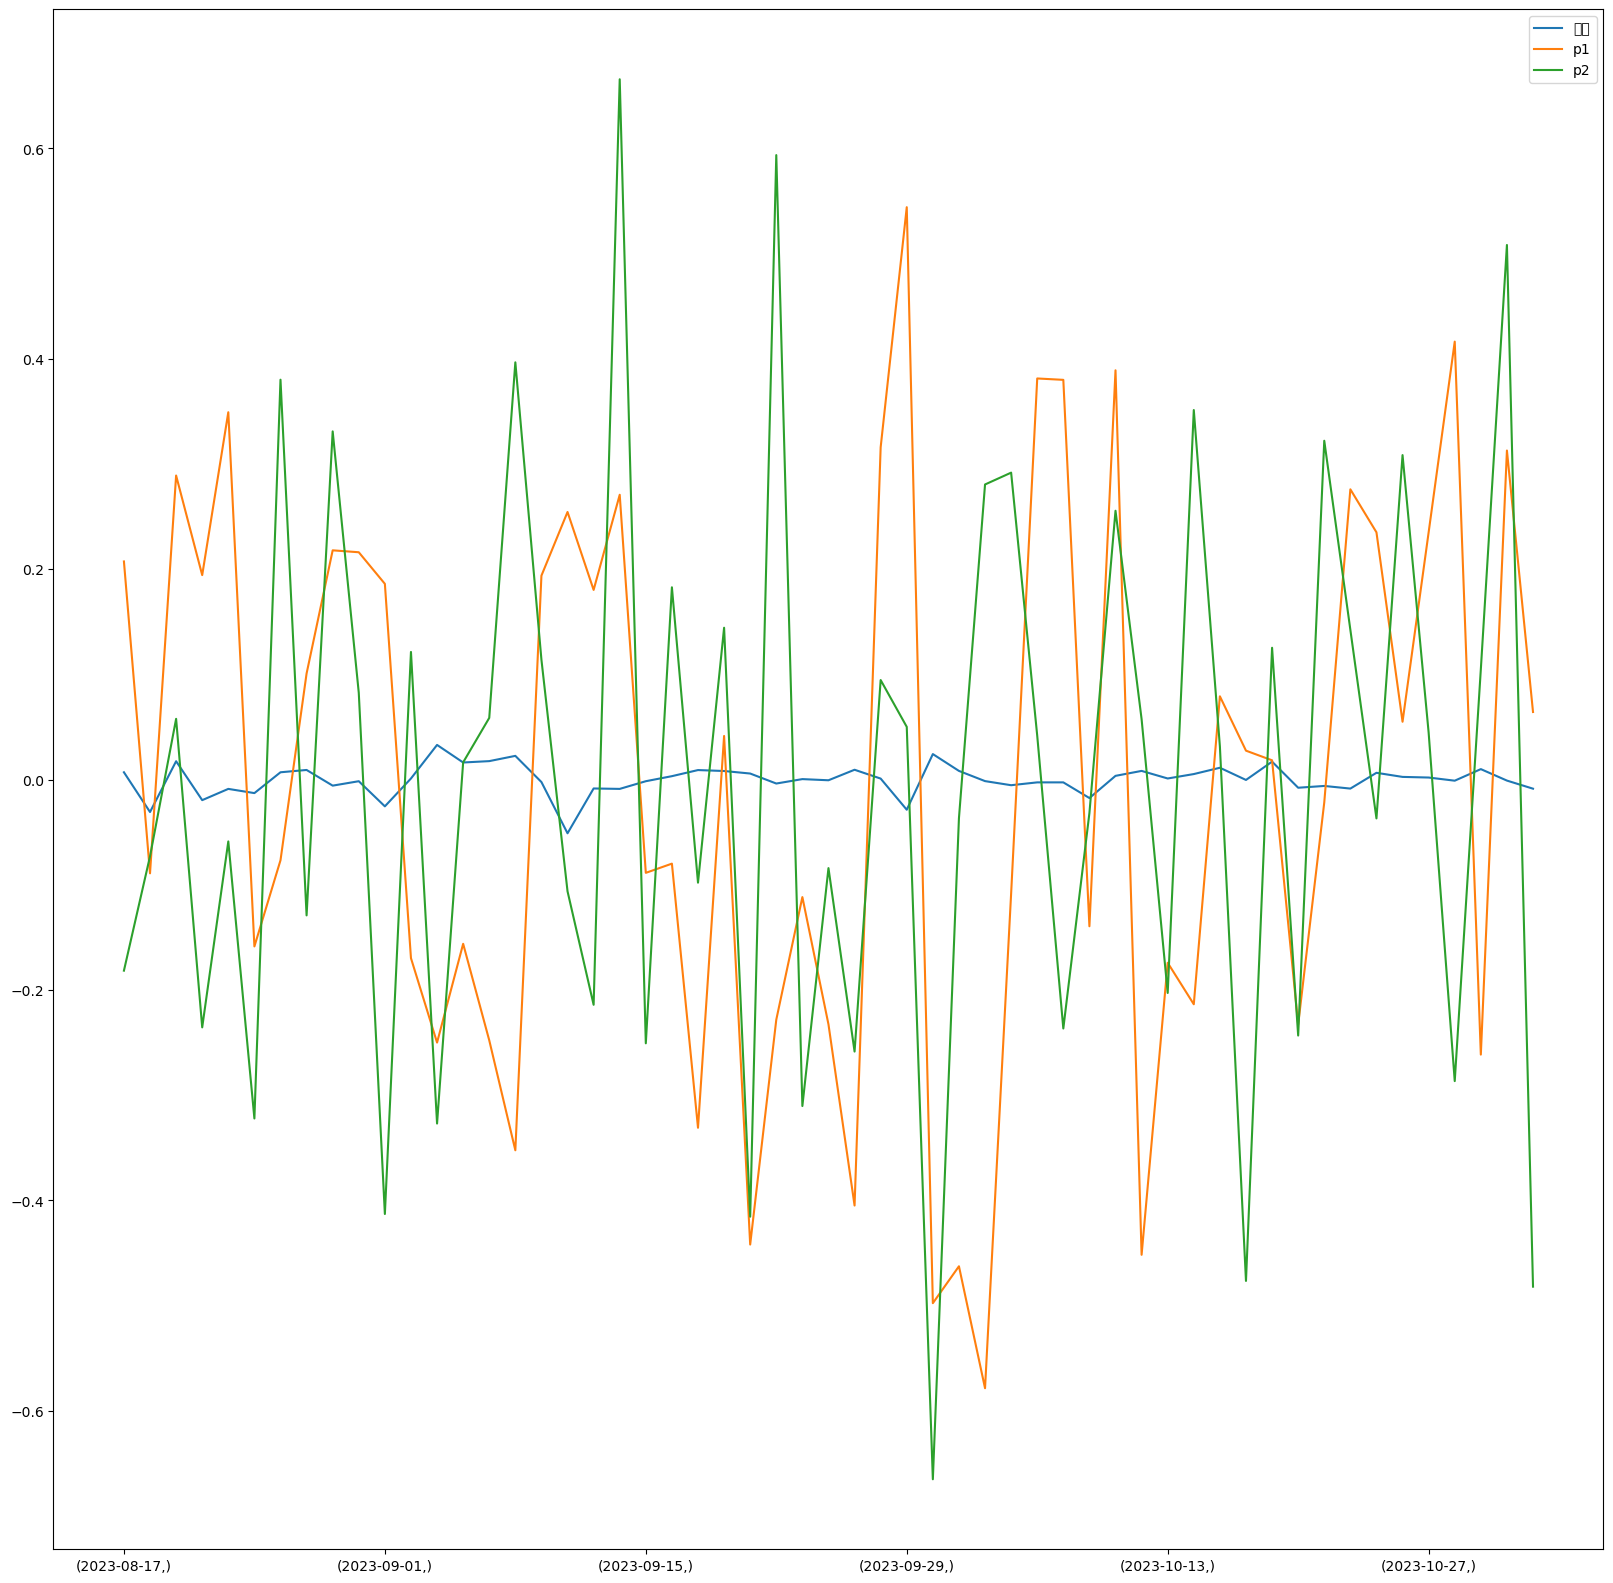

In [353]:
## CNH, p1, p2 plot, in case of diff
df_diff.plot(figsize=(20,20))
print(df_diff)

<Axes: >

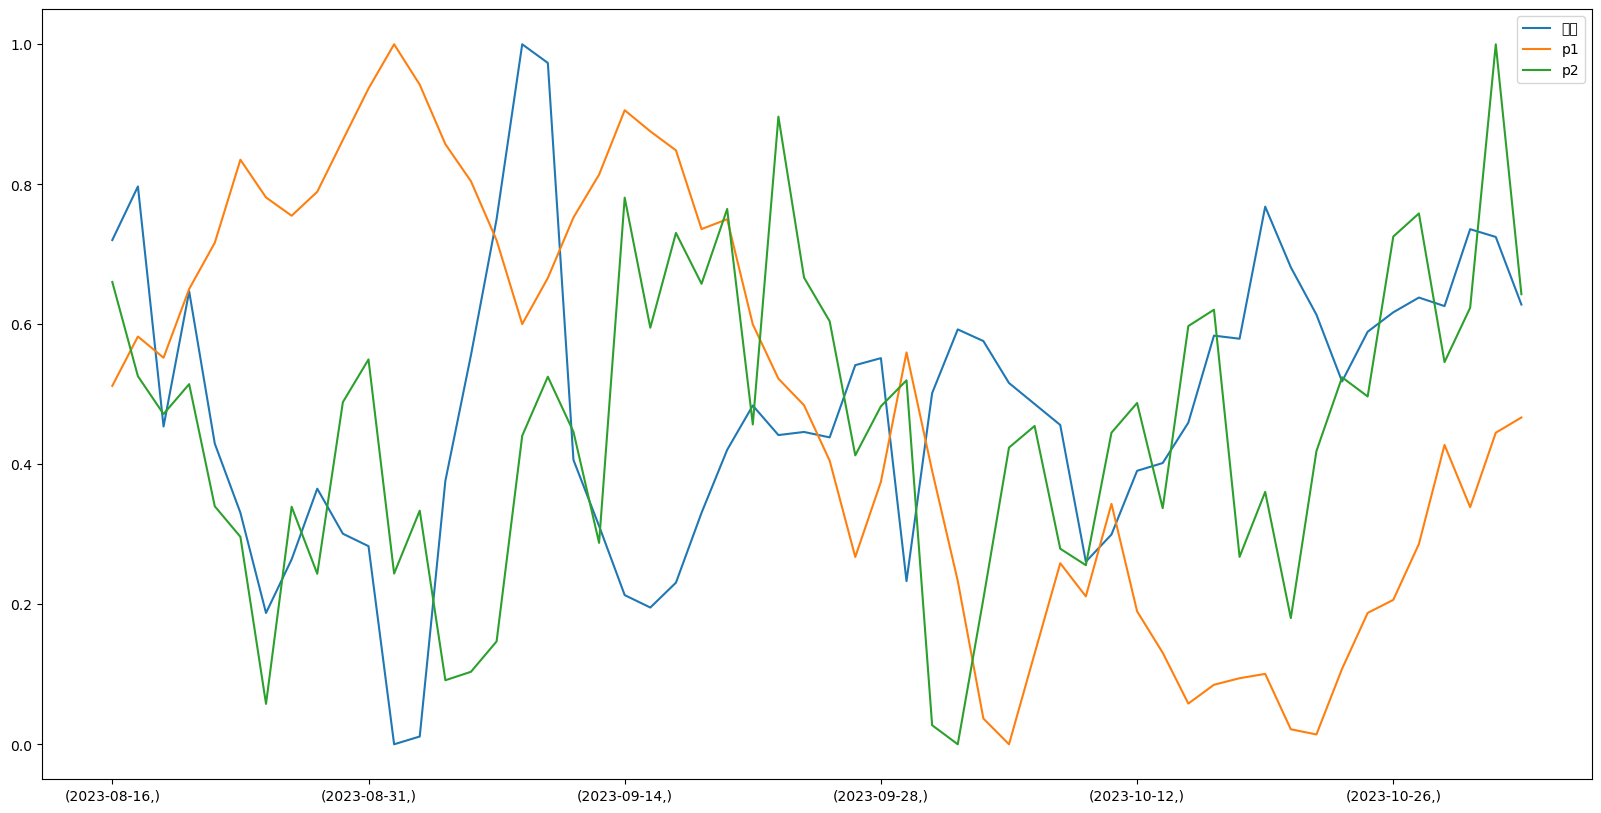

In [354]:
## 차분 안한 경우의 Min-Max 스케일링
# Min-Max 스케일링 함수 정의
scale = pd.DataFrame(df_scale)
def min_max_scaling(df_scale):
    return (df_scale - df_scale.min()) / (df_scale.max() - df_scale.min())

# 스케일링 적용
scaled_df = scale.apply(min_max_scaling)

# 결과 출력
scaled_df.plot(figsize=(20,10))

In [355]:
# 고가, p1, p2의 데이터를 리스트로 정의
high_prices = [7.3432, 7.3501, 7.3192, 7.3366, 7.3170, 7.3081, 7.2952, 7.3021, 7.3112, 7.3054, 7.3038, 7.2783, 7.2793, 7.3122, 7.3284, 7.3459, 7.3684, 7.3660, 7.3149, 7.3064, 7.2975, 7.2959, 7.2991, 7.3081, 7.3162, 7.3219, 7.3181, 7.3185, 7.3178, 7.3271, 7.3280, 7.2993, 7.3235, 7.3317, 7.3302, 7.3248, 7.3221, 7.3194, 7.3018, 7.3053, 7.3135, 7.3145, 7.3197, 7.3309, 7.3305, 7.3475, 7.3397, 7.3336, 7.3250, 7.3314, 7.3339, 7.3358, 7.3347, 7.3446, 7.3436, 7.3349]
p1_values = [0.076188, 0.283515, 0.194337, 0.483345, 0.677676, 1.026860, 0.868182, 0.791408, 0.892223, 1.110121, 1.326194, 1.512239, 1.342433, 1.092356, 0.936179, 0.688259, 0.335800, 0.529635, 0.783990, 0.964249, 1.234967, 1.146255, 1.066298, 0.735238, 0.776670, 0.334595, 0.106276, -0.005484, -0.238255, -0.643247, -0.327371, 0.216741, -0.281083, -0.743820, -1.322486, -1.430806, -1.049522, -0.669549, -0.809048, -0.419988, -0.871822, -1.046014, -1.259676, -1.180552, -1.153107, -1.134829, -1.367754, -1.389514, -1.113610, -0.878575, -0.823636, -0.588599, -0.172287, -0.433787, -0.121003, -0.056804]
p2_values = [0.280231, 0.098536, 0.025555, 0.083254, -0.152361, -0.211201, -0.533442, -0.153322, -0.282478, 0.048501, 0.130914, -0.282126, -0.160834, -0.487875, -0.471550, -0.412956, -0.016326, 0.097547, -0.008717, -0.222850, 0.442869, 0.192095, 0.374849, 0.276803, 0.421117, 0.005534, 0.599171, 0.288771, 0.204555, -0.054061, 0.040515, 0.090590, -0.574644, -0.611386, -0.330886, -0.039131, 0.002529, -0.234157, -0.265954, -0.010422, 0.046902, -0.156009, 0.195266, 0.226798, -0.249875, -0.124599, -0.367981, -0.045910, 0.096439, 0.059468, 0.367908, 0.412504, 0.125801, 0.230588, 0.738774, 0.256665]

# Min-Max 스케일링 함수 정의
def min_max_scaling(data, min_val, max_val):
    scaled_data = [(x - min(data)) / (max(data) - min(data)) * (max_val - min_val) + min_val for x in data]
    return scaled_data

# p1 및 p2 값을 고가에 맞게 스케일링
p1_scaled = min_max_scaling(p1_values, 0, 1)
p2_scaled = min_max_scaling(p2_values, 0, 1)

# 스케일링된 값 출력
print("고가 스케일링 결과:")
print(high_prices)
print("\np1 스케일링 결과:")
print(p1_scaled)
print("\np2 스케일링 결과:")
print(p2_scaled)

고가 스케일링 결과:
[7.3432, 7.3501, 7.3192, 7.3366, 7.317, 7.3081, 7.2952, 7.3021, 7.3112, 7.3054, 7.3038, 7.2783, 7.2793, 7.3122, 7.3284, 7.3459, 7.3684, 7.366, 7.3149, 7.3064, 7.2975, 7.2959, 7.2991, 7.3081, 7.3162, 7.3219, 7.3181, 7.3185, 7.3178, 7.3271, 7.328, 7.2993, 7.3235, 7.3317, 7.3302, 7.3248, 7.3221, 7.3194, 7.3018, 7.3053, 7.3135, 7.3145, 7.3197, 7.3309, 7.3305, 7.3475, 7.3397, 7.3336, 7.325, 7.3314, 7.3339, 7.3358, 7.3347, 7.3446, 7.3436, 7.3349]

p1 스케일링 결과:
[0.5120526529495811, 0.5824990783355334, 0.5521978087321124, 0.650398142060349, 0.7164287328260356, 0.8350759162703935, 0.7811596492748157, 0.7550730620836582, 0.7893283996676911, 0.8633666831461971, 0.9367848605780748, 1.0, 0.9423026151485961, 0.8573304179854538, 0.8042639511118587, 0.720024668328211, 0.6002646918412732, 0.6661267496759308, 0.7525525433691974, 0.8138016917852089, 0.905787373281754, 0.8756444430853079, 0.8484763229920033, 0.7359873872129036, 0.7500653234999803, 0.5998552519584308, 0.5222760780076418, 0.48430

<Axes: >

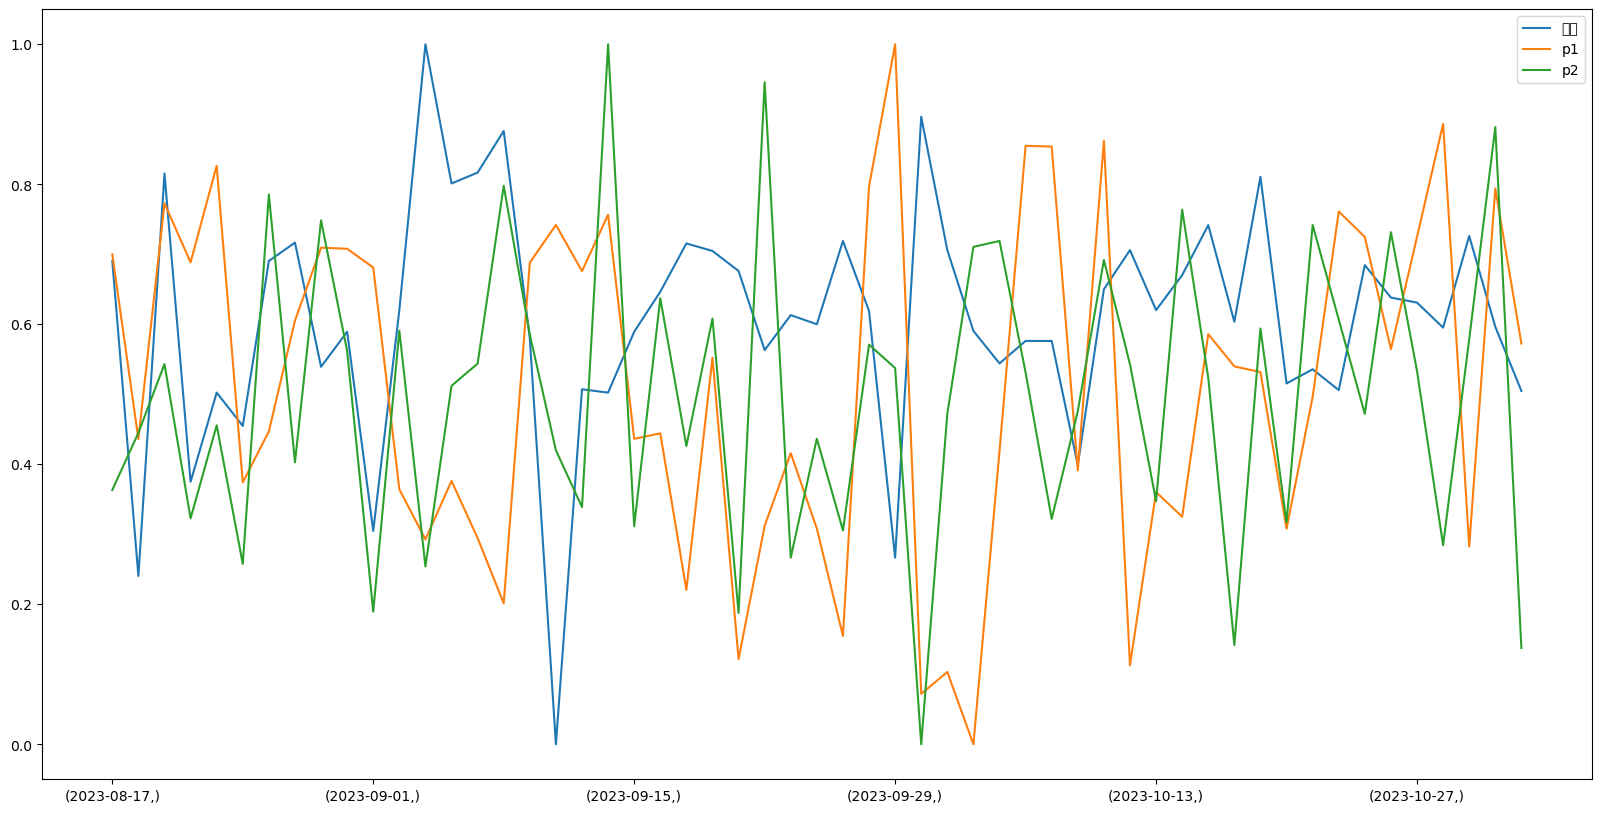

In [356]:
## 차분한 경우의 Min-Max 스케일링 -> 채택
# Min-Max 스케일링 함수 정의
scale = pd.DataFrame(df_diff)
def min_max_scaling(df_diff):
    return (df_diff - df_diff.min()) / (df_diff.max() - df_diff.min())

# 스케일링 적용
scaled_df = scale.apply(min_max_scaling)

# 결과 출력
scaled_df.plot(figsize=(20,10))

In [337]:
## 예측 및 추세선 학습을 위한 VAR 모델링_차분 안한 경우
#최근30일 간의 데이터 예측 및 테스트를 위해 분리
train = df_scale.iloc[:-30,:]
test = df_scale.iloc[-30:,:]

#VAR모델 선언 및 최적값을 찾기위해 AIC 확인
forecasting_model = VAR(train)
results_aic = []
for p in range(1,30):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

C:\Users\JeongheeLee\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LinAlgError: 3-th leading minor of the array is not positive definite

In [357]:
## 예측 및 추세선 학습을 위한 VAR 모델링_차분 안한 경우
#최근30일 간의 데이터 예측 및 테스트를 위해 분리
train = df_diff.iloc[:-30,:]
test = df_diff.iloc[-30:,:]

#VAR모델 선언 및 최적값을 찾기위해 AIC 확인
forecasting_model = VAR(train)
results_aic = []
for p in range(1,30):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

C:\Users\JeongheeLee\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: x contains one or more constant columns. Column(s) 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71 are constant. Adding a constant with trend='c' is not allowed.

KeyError: '날짜'

In [302]:
## n_components = 1 에서의 PCA 수행
pca = PCA(n_components=1)
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['p1'])
principalDf.head()

,p1
0,0.076188
1,0.283515
2,0.194337
3,0.483345
4,0.677676


In [303]:
# 설명력 확인
pca.explained_variance_ratio_

array([0.85874785])

In [304]:
# 데이터 전체 확인
principalDf.index = CNH_df_Hi_Time
principalDf

,p1
"(2023-08-16,)",0.076188
"(2023-08-17,)",0.283515
"(2023-08-18,)",0.194337
"(2023-08-21,)",0.483345
"(2023-08-22,)",0.677676
"(2023-08-23,)",1.026860
"(2023-08-24,)",0.868182
"(2023-08-25,)",0.791408
"(2023-08-29,)",0.892223
"(2023-08-30,)",1.110121


In [305]:
## 데이터 정리
# 주성분 분리
pc1 = np.array(principalDf['p1'])

# CNH 데이터 정리
CNH_df_Hi_com.index = CNH_df_Hi_Time
y = CNH_df_Hi_com.iloc[:,0]
principalDf.index = CNH_df_Hi_Time
principalDf

,p1
"(2023-08-16,)",0.076188
"(2023-08-17,)",0.283515
"(2023-08-18,)",0.194337
"(2023-08-21,)",0.483345
"(2023-08-22,)",0.677676
"(2023-08-23,)",1.026860
"(2023-08-24,)",0.868182
"(2023-08-25,)",0.791408
"(2023-08-29,)",0.892223
"(2023-08-30,)",1.110121


In [306]:
## 주성분 분석 데이터와 타겟 데이터 병합
df = pd.merge(y, principalDf,left_index=True, right_index=True,how='inner')
df_scale = pd.DataFrame(df)
df 

,고가,p1
"(2023-08-16,)",7.3432,0.076188
"(2023-08-17,)",7.3501,0.283515
"(2023-08-18,)",7.3192,0.194337
"(2023-08-21,)",7.3366,0.483345
"(2023-08-22,)",7.3170,0.677676
"(2023-08-23,)",7.3081,1.026860
"(2023-08-24,)",7.2952,0.868182
"(2023-08-25,)",7.3021,0.791408
"(2023-08-29,)",7.3112,0.892223
"(2023-08-30,)",7.3054,1.110121


In [307]:
## 정상성 확인
# 컬럼별로 정상성확인하는 함수
for i in df.columns:
    adfuller_test = adfuller(df[i],autolag='AIC')
    print(i)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))

고가
ADF test statistic: -3.8978466655190345
p-value: 0.0020507517390630134
p1
ADF test statistic: -1.4402173016918474
p-value: 0.5628509032694093


In [308]:
# 차분 구하기
df_diff = df.diff().dropna()

# 차분 후 정상성 재확인
for i in df.columns:
    adfuller_test = adfuller(df_diff[i],autolag='AIC')
    print(i)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))

고가
ADF test statistic: -5.290987646475525
p-value: 5.715999971897806e-06
p1
ADF test statistic: -5.830370930857839
p-value: 3.988202754515861e-07


                   고가        p1
(2023-08-17,)  0.0069  0.207326
(2023-08-18,) -0.0309 -0.089177
(2023-08-21,)  0.0174  0.289007
(2023-08-22,) -0.0196  0.194331
(2023-08-23,) -0.0089  0.349184
(2023-08-24,) -0.0129 -0.158678
(2023-08-25,)  0.0069 -0.076774
(2023-08-29,)  0.0091  0.100815
(2023-08-30,) -0.0058  0.217898
(2023-08-31,) -0.0016  0.216073
(2023-09-01,) -0.0255  0.186045
(2023-09-04,)  0.0010 -0.169806
(2023-09-05,)  0.0329 -0.250076
(2023-09-06,)  0.0162 -0.156177
(2023-09-07,)  0.0175 -0.247920
(2023-09-08,)  0.0225 -0.352459
(2023-09-11,) -0.0024  0.193835
(2023-09-12,) -0.0511  0.254355
(2023-09-13,) -0.0085  0.180259
(2023-09-14,) -0.0089  0.270718
(2023-09-15,) -0.0016 -0.088712
(2023-09-18,)  0.0032 -0.079957
(2023-09-19,)  0.0090 -0.331060
(2023-09-20,)  0.0081  0.041432
(2023-09-21,)  0.0057 -0.442075
(2023-09-22,) -0.0038 -0.228319
(2023-09-25,)  0.0004 -0.111760
(2023-09-26,) -0.0007 -0.232771
(2023-09-27,)  0.0093 -0.404992
(2023-09-28,)  0.0009  0.315875
(2023-09

C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  func(*args, **kwargs)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


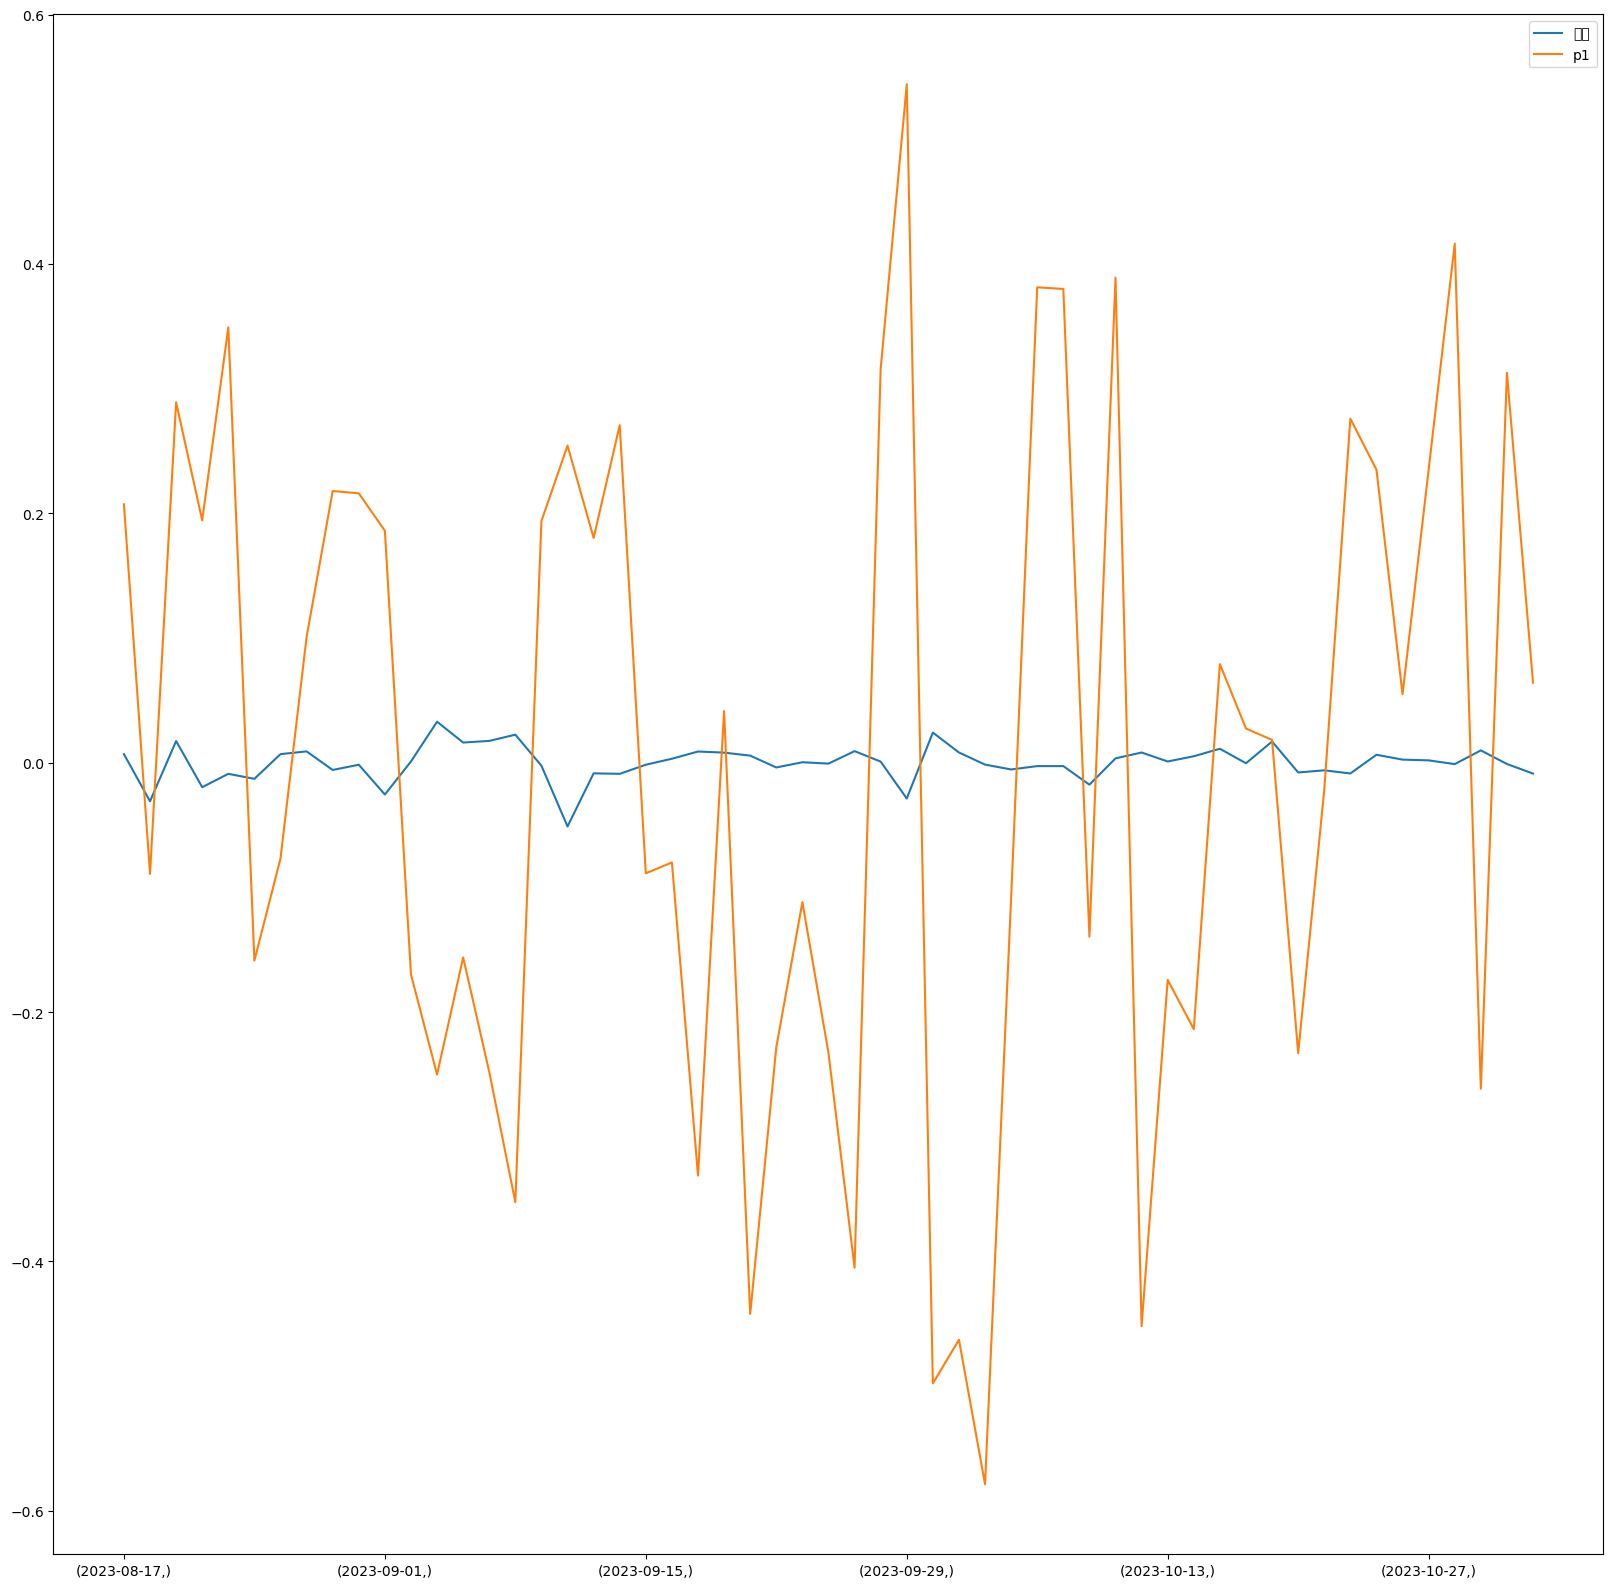

In [309]:
# CNH, p1 plot, in case of diff
df_diff.plot(figsize=(20,20))
print(df_diff)

<Axes: >

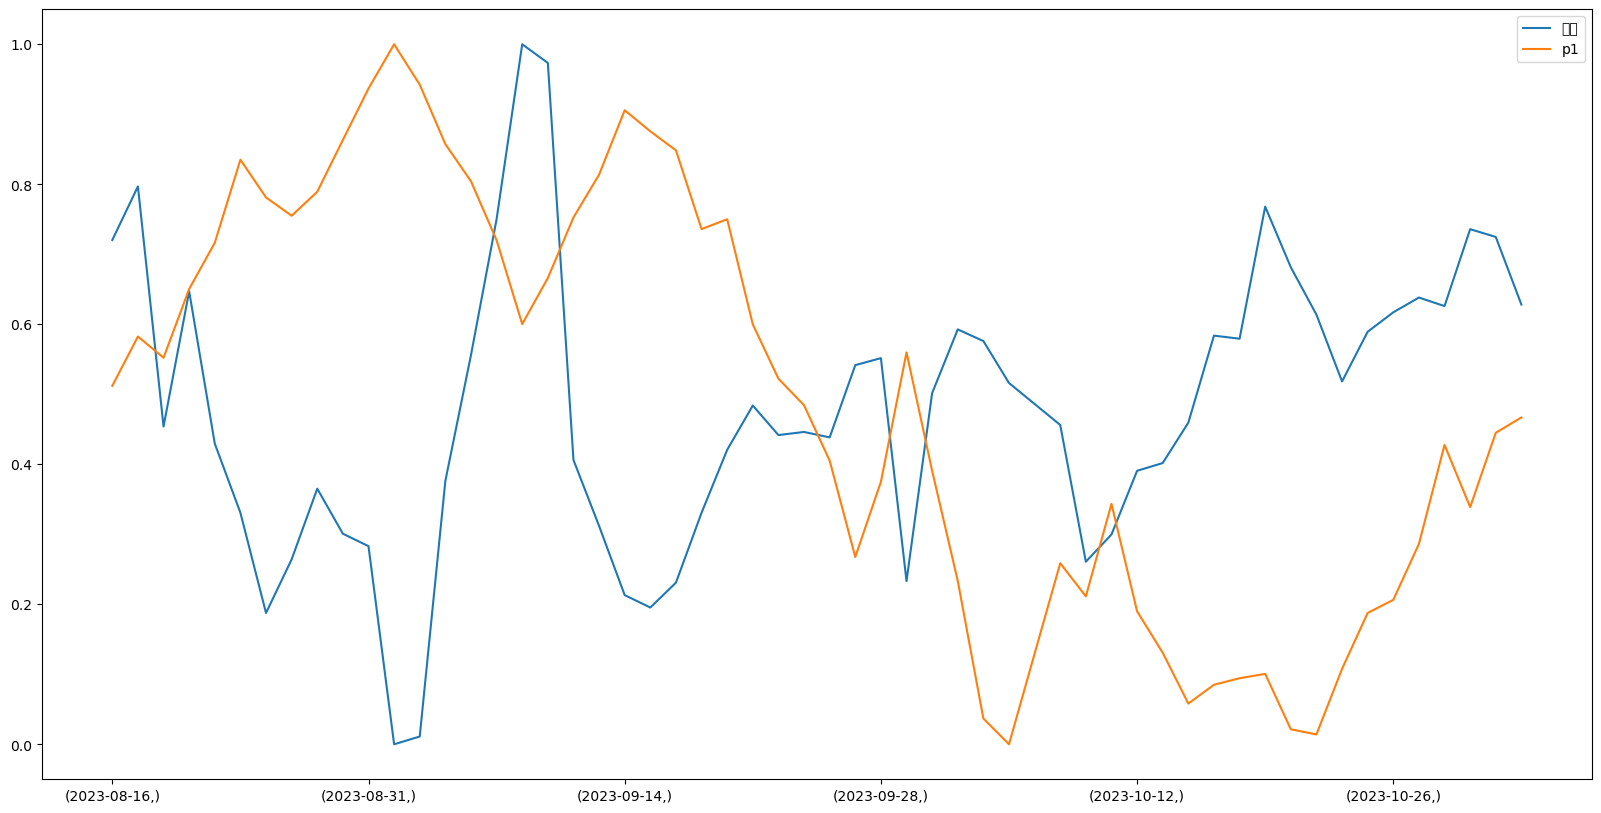

In [311]:
# Min-Max 스케일링 함수 정의
scale = pd.DataFrame(df)
def min_max_scaling(df):
    return (df - df.min()) / (df.max() - df.min())

# 스케일링 적용
scaled_df = scale.apply(min_max_scaling)

# 결과 출력
scaled_df.plot(figsize=(20,10))

In [ ]:
## PCA 결과 중간정리
# 2개 주성분 추출 결과: diff 후 fitting 시 PC2가 가장 유사한 추세를 보임(이후 방법 실패시 해당 선 scaling 할 것)
# 1개 주성분 추출 결과: 사용불가능

In [312]:
#최근30일 간의 데이터 예측 및 테스트를 위해 분리
train = df_diff.iloc[:-30,:]
test = df_diff.iloc[-30:,:]

#VAR모델 선언 및 최적값을 찾기위해 AIC 확인
forecasting_model = VAR(train)
results_aic = []
for p in range(1,30):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

C:\Users\JeongheeLee\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: x contains one or more constant columns. Column(s) 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47 are constant. Adding a constant with trend='c' is not allowed.

In [154]:
#최적의 AIC값을 나타내는 순서 인덱스 추출
np.argsort(results_aic)[0]

4

In [156]:
#모델 피팅
results = forecasting_model.fit(np.argsort(results_aic)[0])
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Nov, 2023
Time:                     20:39:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -28.4668
Nobs:                     22.0000    HQIC:                  -29.9453
Log likelihood:           279.760    FPE:                1.06357e-13
AIC:                     -30.4009    Det(Omega_mle):     2.64138e-14
--------------------------------------------------------------------
Results for equation 종가
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000675         0.004935            0.137           0.891
L1.종가         1.106469         3.312661            0.334           0.738
L1.p1         1.066838         1.648994            0.647           0.518
L1.p2         3.595308

In [157]:
#차분 값에 대한 다변량 시계열 분석 진행
laaged_values = train.values
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=30), index = test.index,\
                        columns=df.columns)
forecast

,종가,p1,p2
2023-09-22,-1.046777e-02,-0.000815,0.015978
2023-09-25,3.469170e-03,-0.007109,-0.012471
2023-09-26,-1.292960e-02,-0.014081,0.011651
2023-09-27,-3.223368e-03,-0.013265,-0.006808
2023-09-28,-1.014142e-03,-0.004065,-0.002241
2023-09-29,4.866090e-03,0.005109,-0.005088
2023-10-02,5.962130e-03,0.009381,-0.000836
2023-10-03,2.964670e-03,0.008885,0.002699
2023-10-04,-5.328119e-04,0.002362,0.002774
2023-10-05,-2.586652e-03,-0.002162,0.000843


In [159]:
#축적된 값을 더하여 실제 예측값 구하기(ticketing_count_forecasted가 예측값임)
for i in df.columns:
    forecast[f'{i}_forecasted']= df[i].iloc[-30-1]+forecast[i].cumsum()
print(forecast)

                      종가        p1        p2  종가_forecasted  p1_forecasted  \
2023-09-22 -1.046777e-02 -0.000815  0.015978       7.303732       0.007537   
2023-09-25  3.469170e-03 -0.007109 -0.012471       7.307201       0.000428   
2023-09-26 -1.292960e-02 -0.014081  0.011651       7.294272      -0.013652   
2023-09-27 -3.223368e-03 -0.013265 -0.006808       7.291048      -0.026918   
2023-09-28 -1.014142e-03 -0.004065 -0.002241       7.290034      -0.030983   
2023-09-29  4.866090e-03  0.005109 -0.005088       7.294900      -0.025874   
2023-10-02  5.962130e-03  0.009381 -0.000836       7.300863      -0.016493   
2023-10-03  2.964670e-03  0.008885  0.002699       7.303827      -0.007608   
2023-10-04 -5.328119e-04  0.002362  0.002774       7.303294      -0.005245   
2023-10-05 -2.586652e-03 -0.002162  0.000843       7.300708      -0.007407   
2023-10-06 -2.852571e-03 -0.005847 -0.000184       7.297855      -0.013254   
2023-10-09 -2.646051e-03 -0.005870 -0.000451       7.295209     

<Axes: >

C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  func(*args, **kwargs)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


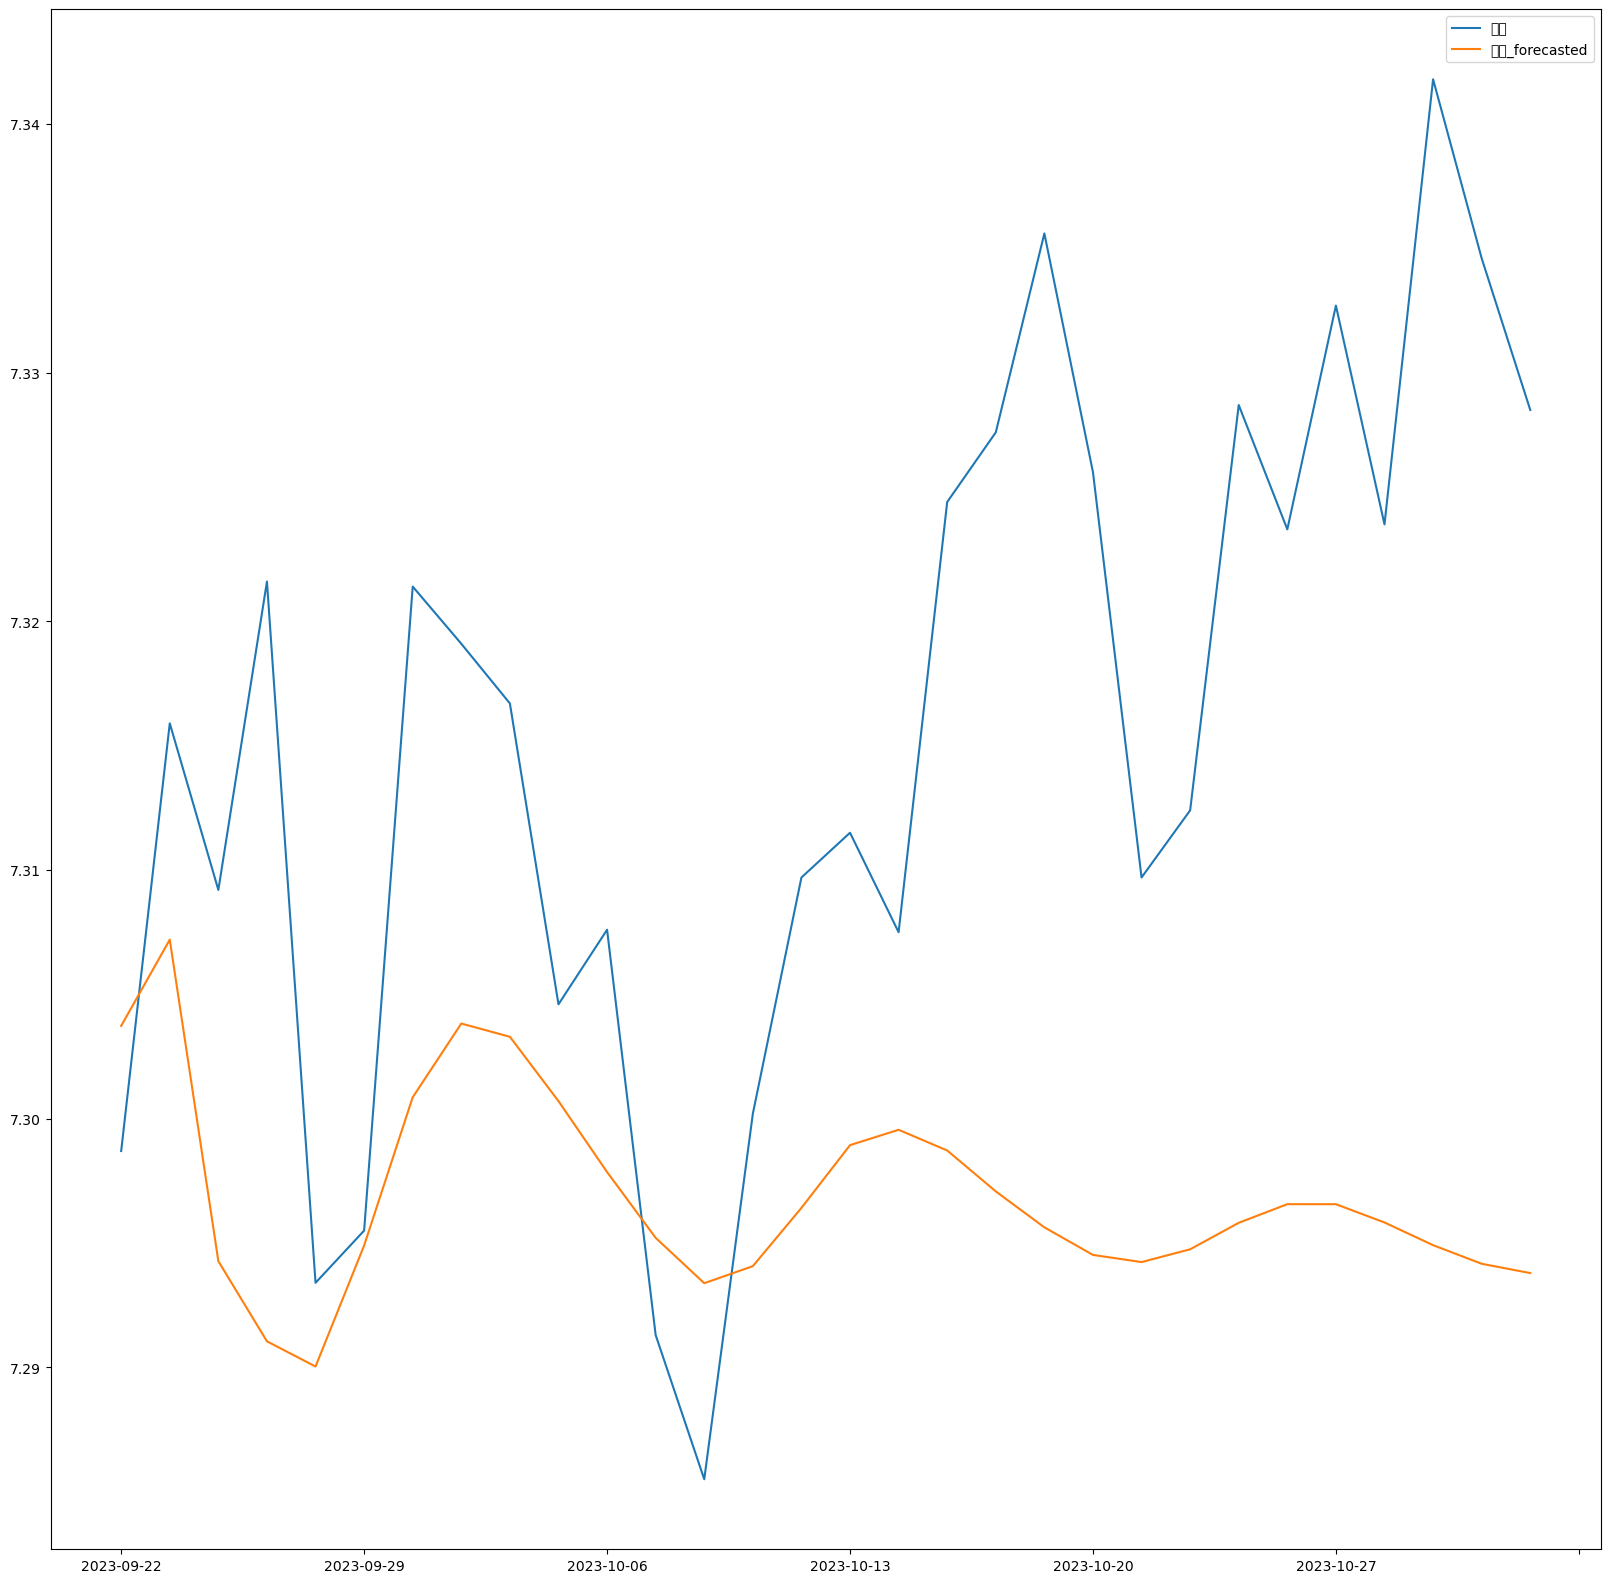

In [160]:
#예측값과 실제값 확인 (2021/08/02~2021/08/31 기간 내)
test = df.iloc[-30:,:1]
for i in test.columns:
    test[f'{i}_forecasted'] = forecast[f'{i}_forecasted']
test.plot(figsize=(20,20))